# Baseline Models

We've got our data for the 8 counties in Colorado, now we have to find the 5 best zip codes to recommend to our client. Before we use any of our more advanced modeling, we'll start off with some basic modeling, namely a persistence model and assess how it does. This will be our baseline model, moving forward if any of our models fail to meet the standards of this one we'll have to reassess them.

Along with doing our baseline models, we'll want to get an overview of the zip codes, inspecting for any non-stationarity, and then inducing stationarity if we can.

In [1]:
# import libaries
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats

import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets
from functools import partial

%matplotlib inline
sns.set(font_scale=1.2)

In [2]:
# load data
df = pd.read_csv("../data/interim/co-data.csv", index_col="Date", parse_dates=True)
df.head()

,RegionID,RegionName,City,State,CountyName,SizeRank,value
Date,,,,,,,
1996-04-01,93295,80219,Denver,CO,Denver,611,83700.0
1996-04-01,93252,80123,Denver,CO,Denver,753,163900.0
1996-04-01,93305,80229,Thornton,CO,Adams,943,93800.0
1996-04-01,93309,80233,Northglenn,CO,Adams,1106,110100.0
1996-04-01,93296,80220,Denver,CO,Denver,1249,138500.0


In [3]:
df[df.RegionName == 80219]

,RegionID,RegionName,City,State,CountyName,SizeRank,value
Date,,,,,,,
1996-04-01,93295,80219,Denver,CO,Denver,611,83700.0
1996-05-01,93295,80219,Denver,CO,Denver,611,84000.0
1996-06-01,93295,80219,Denver,CO,Denver,611,84300.0
1996-07-01,93295,80219,Denver,CO,Denver,611,84700.0
1996-08-01,93295,80219,Denver,CO,Denver,611,85100.0
...,...,...,...,...,...,...,...
2017-12-01,93295,80219,Denver,CO,Denver,611,298100.0
2018-01-01,93295,80219,Denver,CO,Denver,611,302600.0
2018-02-01,93295,80219,Denver,CO,Denver,611,306900.0


In [4]:
# plot market trend for each zip code
def plot_zip(zipcode):
    zip_series = df.loc[df.RegionName == zipcode, "value"]
    plt.figure(figsize=(16, 9))
    zip_series.plot(title=f"{zipcode} Historic Median Home Value", label="Observations")
    zip_series.rolling(3).mean().plot(label="Quarterly Rolling Mean")
    zip_series.rolling(12).mean().plot(label="Annual Rolling Mean")
    zip_series.rolling(12).std().plot(label="Annual Rolling STD")
    
    plt.legend()
    
    adf = sm.tsa.stattools.adfuller(zip_series)
    print(f"ADF Test Stat: {adf[0]:.3f}")
    print(f"ADF P-Value: {adf[1]:.2%}")
    print(*[f"|{k}: {v:.3f}|" for k, v in adf[4].items()])
    
    

selection = ipywidgets.widgets.Dropdown(options=df.RegionName.sort_values().unique())
i = ipywidgets.interact(plot_zip, zipcode=selection)
plt.show()

interactive(children=(Dropdown(description='zipcode', options=(80021, 80022, 80030, 80031, 80102, 80123, 80136…

In [5]:
# output stationary zip codes
adf_scores = df.pivot(columns="RegionName", values="value").apply(sm.tsa.stattools.adfuller).transpose()[1]
adf_scores[adf_scores < .05]

Series([], Name: 1, dtype: object)

## Inducing Stationarity

As expected all of our zip codes are non-stationary, looking through the zip codes we can see a positive trend for a majority of them. Maybe taking the first difference will make a difference (ba dum tsh).

### First Difference

In [6]:
# plot market trend for each zip code after the first difference
def plot_zip(zipcode):
    zip_series = df.loc[df.RegionName == zipcode, "value"].diff().dropna()
    plt.figure(figsize=(16, 9))
    zip_series.plot(title=f"{zipcode} Historic Median Home Value", label="Observations")
    zip_series.rolling(12).mean().plot(label="Annual Rolling Mean")
    zip_series.rolling(12).std().plot(label="Annual Rolling STD")
    
    plt.legend()
    
    adf = sm.tsa.stattools.adfuller(zip_series)
    print(f"ADF Test Stat: {adf[0]:.3f}")
    print(f"ADF P-Value: {adf[1]:.2%}")
    print(*[f"|{k}: {v:.3f}|" for k, v in adf[4].items()])
    print(f"Level: {zip_series.mean():.4f}")
    
    

selection = ipywidgets.widgets.Dropdown(options=df.RegionName.sort_values().unique())
i = ipywidgets.interact(plot_zip, zipcode=selection)
plt.show()

interactive(children=(Dropdown(description='zipcode', options=(80021, 80022, 80030, 80031, 80102, 80123, 80136…

Looking through the visuals of our differenced time series, the mean still appears to vary consistently and not stay constant. We are also left with a very large amount of variation in each time series standard deviation through time.

This does look more like a random walk, maybe taking a second difference will help.

### Second Difference

In [7]:
# plot market trend for each zip code after the first difference
def plot_zip(zipcode):
    zip_series = df.loc[df.RegionName == zipcode, "value"].diff().diff().dropna()
    plt.figure(figsize=(16, 9))
    zip_series.plot(title=f"{zipcode} Historic Median Home Value", label="Observations")
    zip_series.rolling(12).mean().plot(label="Annual Rolling Mean")
    zip_series.rolling(12).std().plot(label="Annual Rolling STD")
    
    plt.legend()
    
    adf = sm.tsa.stattools.adfuller(zip_series)
    print(f"ADF Test Stat: {adf[0]:.3f}")
    print(f"ADF P-Value: {adf[1]:.2%}")
    print(*[f"|{k}: {v:.3f}|" for k, v in adf[4].items()])
    print(f"Level: {zip_series.mean():.4f}")
    
    

selection = ipywidgets.widgets.Dropdown(options=df.RegionName.sort_values().unique())
i = ipywidgets.interact(plot_zip, zipcode=selection)
plt.show()

interactive(children=(Dropdown(description='zipcode', options=(80021, 80022, 80030, 80031, 80102, 80123, 80136…

In [8]:
# output stationary zip codes
adf_scores2 = df.pivot(columns="RegionName", values="value").diff().diff().dropna().apply(sm.tsa.stattools.adfuller).transpose()[1]
adf_scores2[adf_scores2 < .05]
adf_scores2

RegionName
80021    0.000629569
80022    6.44262e-07
80030    1.32108e-06
80031    1.57969e-08
80102    8.84388e-11
            ...     
81211    0.000214877
81224    1.71589e-07
81225    8.04766e-07
81230    1.30421e-06
81236    5.23966e-09
Name: 1, Length: 61, dtype: object

All 61 of our series have rejected the null hypothesis with a 95% confidence. These series have become stationary. 

The only problem is we may have over differenced. One noticeable thing about these 2nd order differenced series, is that their variation becomes extreme towards the end of the series. Maybe we should first try a power transformation and then identify if it helps, we'll use the boxcox transformation.

### Power Transformation

In [9]:
# plot market trend for each zip code
def plot_zip(zipcode):
    trans, lmbda = stats.boxcox(df.loc[df.RegionName == zipcode, "value"])
    zip_series = pd.Series(trans)
    
    plt.figure(figsize=(16, 9))
    plt.subplot(3, 1, (1, 2))
    zip_series.plot(title=f"{zipcode} Historic Median Home Value", label="Observations")
    zip_series.rolling(12).mean().plot(label="Annual Rolling Mean")
    plt.legend()
    plt.subplot(3, 1, 3)
    zip_series.rolling(12).std().plot(label="Annual Rolling STD")
    
    plt.legend()
    
    adf = sm.tsa.stattools.adfuller(zip_series)
    print(f"ADF Test Stat: {adf[0]:.3f}")
    print(f"ADF P-Value: {adf[1]:.2%}")
    print(*[f"|{k}: {v:.3f}|" for k, v in adf[4].items()])
    print(f"Boxcox Lambda: {lmbda:g}")
    
    

selection = ipywidgets.widgets.Dropdown(options=df.RegionName.sort_values().unique())
i = ipywidgets.interact(plot_zip, zipcode=selection)
plt.show()

interactive(children=(Dropdown(description='zipcode', options=(80021, 80022, 80030, 80031, 80102, 80123, 80136…

Our power transforms aren't any more beneficial, since there isn't much noise in the data to begin with. Maybe if we smooth our data, it will help.

### Resampling + First Difference

In [10]:
# plot market trend for each zip code after the first difference
def plot_zip(zipcode):
    zip_series = df.loc[df.RegionName == zipcode, "value"].resample("Q").mean().diff().dropna()
    plt.figure(figsize=(16, 9))
    zip_series.plot(title=f"{zipcode} Historic Median Home Value", label="Observations")
    zip_series.rolling(12).mean().plot(label="Annual Rolling Mean")
    zip_series.rolling(12).std().plot(label="Annual Rolling STD")
    
    plt.legend()
    
    adf = sm.tsa.stattools.adfuller(zip_series)
    print(f"ADF Test Stat: {adf[0]:.3f}")
    print(f"ADF P-Value: {adf[1]:.2%}")
    print(*[f"|{k}: {v:.3f}|" for k, v in adf[4].items()])
    print(f"Level: {zip_series.mean():.4f}")
    
    

selection = ipywidgets.widgets.Dropdown(options=df.RegionName.sort_values().unique())
i = ipywidgets.interact(plot_zip, zipcode=selection)
plt.show()

interactive(children=(Dropdown(description='zipcode', options=(80021, 80022, 80030, 80031, 80102, 80123, 80136…

The problem seems to have now been exacerbated. We'll continue on from here and go into persistence modeling using just the second order differencing.

## Persistence Modeling

Persistance modeling is simple just return the current value as the prediction for the next one.

In [11]:
def persist(value):
    """Return the value"""
    return value

In [12]:
def model(series):
    """Using persistance create a model and return the RMSE score"""
    data = pd.concat([series, series.shift(-1)], axis=1).dropna().values
    X, y = data[:, 0], data[:, 1]
    size = int(data.shape[0] * .66)
    X_train, X_test, y_train, y_test = X[:size], X[size:], y[:size], y[size:]
    y_preds = persist(X_test)
    
    return metrics.mean_squared_error(y_test, y_preds, squared=False)

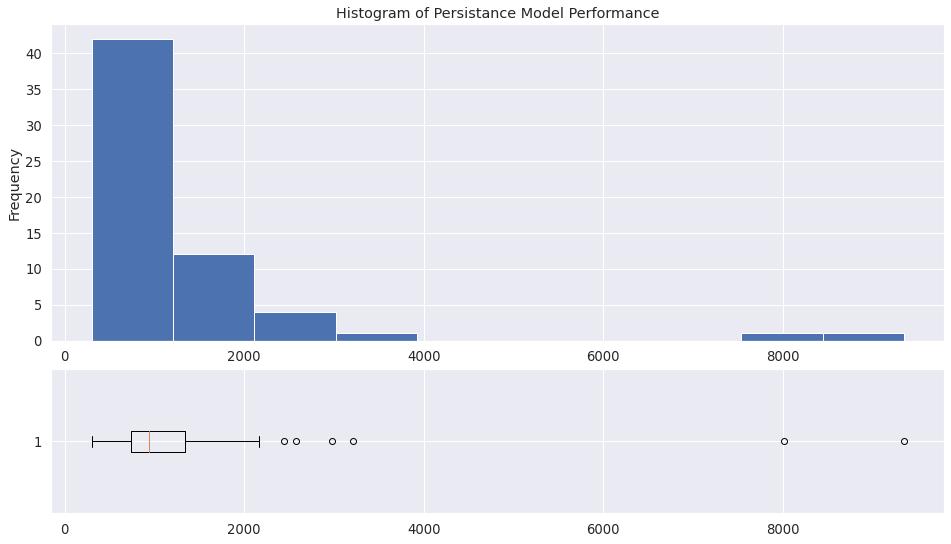

In [13]:
# create pivoted data
diffed_df = df.pivot(columns="RegionName", values="value").diff().diff().dropna()
results = diffed_df.apply(model)
plt.subplot(3, 1, (1, 2))
results.plot(kind="hist", figsize=(16, 9), title="Histogram of Persistance Model Performance")
plt.subplot(3, 1, 3)
plt.boxplot(results, vert=False)
plt.show()

In [14]:
# output results describe
results.describe()

count      61.000000
mean     1338.534285
std      1484.298036
min       306.412939
25%       736.131027
50%       940.094558
75%      1338.116421
max      9346.187577
dtype: float64

In [15]:
# output second order diffed df for reference
diffed_df.describe()

RegionName,80021,80022,80030,80031,80102,80123,80136,80203,80204,80205,...,80816,80827,80863,81101,81201,81211,81224,81225,81230,81236
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,...,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,9.885932,9.125475,8.745247,10.266160,18.250951,9.885932,9.885932,28.136882,17.110266,20.912548,...,4.182510,-4.562738,6.844106,-3.422053,9.125475,12.167300,-104.562738,-69.961977,-31.178707,13.688213
std,405.093037,431.923175,397.750766,399.915456,973.292977,480.673417,1064.403744,760.252537,453.792348,512.943091,...,322.119645,665.377482,397.548214,171.287448,782.777641,755.592545,4197.406744,4172.260586,1488.870075,1153.637993
min,-1400.000000,-1300.000000,-1500.000000,-1500.000000,-3700.000000,-1700.000000,-7700.000000,-3800.000000,-1900.000000,-2800.000000,...,-1700.000000,-3000.000000,-2300.000000,-700.000000,-3800.000000,-4000.000000,-25300.000000,-22700.000000,-7000.000000,-6000.000000
25%,-100.000000,-150.000000,-100.000000,-200.000000,-400.000000,-100.000000,-200.000000,-300.000000,-100.000000,-100.000000,...,-200.000000,-150.000000,-200.000000,-100.000000,-200.000000,-200.000000,-400.000000,-700.000000,-200.000000,-500.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,100.000000,100.000000,100.000000,150.000000,450.000000,200.000000,300.000000,300.000000,100.000000,200.000000,...,200.000000,200.000000,200.000000,100.000000,300.000000,300.000000,450.000000,700.000000,200.000000,500.000000
max,1500.000000,2000.000000,1400.000000,1700.000000,2900.000000,2100.000000,5200.000000,4000.000000,1900.000000,2100.000000,...,1300.000000,3100.000000,1500.000000,600.000000,3100.000000,3000.000000,26700.000000,24000.000000,9900.000000,3700.000000


Looking at our persistance models performance, since we have differenced our data twice it is difficult to understand, but for the most part it seems like for the majority of models our persistance model works decently. Especially since the standard deviation for the majority of our series are within the hundreds to thousands range.

When we move onto SARIMA/ARIMA modeling we'll have to remember to use a second order difference, and look into finding the optimal number of AR/MA for each individual series.